# Training feature selection

## Background



## Description

This notebook demonstrates how to explore the correlations between the features extracted in the [feature extracion notebook][3_Training_feature_extraction.ipynb], and remove the highly coorelated features because they increase the complexity of the model without enhancing its prediction performance.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import json
import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from odc.io.cgroups import get_cpu_quota
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    cross_validate,
)
from sklearn import model_selection
from sklearn.metrics import  accuracy_score,confusion_matrix,precision_score, recall_score

## Read in training data and label dictionary

### Define the data and label paths

In [2]:
# Training data file from previous step
data_path = "results/single_crops_merged_training_features_all_2021.txt"

# Dictionary with class labels from previous step
labels_path = "results/class_labels.json"

### Load the data and identify the feature columns for the model

In [3]:
# load the data
model_input = np.loadtxt(data_path)

# load the column_names
with open(data_path, "r") as file:
    header = file.readline()

# Remove comment symbol from header, then extract label and feature names
column_names = header.split()[1:]

label_col = column_names[0]
feature_cols = column_names[1:]

print(f"Label column:\n{label_col}\n")
print(f"Feature columns:\n{feature_cols}\n")
print('number of features: ',len(feature_cols))

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

Label column:
label

Feature columns:
['blue_s2_Q4_2021', 'green_s2_Q4_2021', 'red_s2_Q4_2021', 'nir_s2_Q4_2021', 'swir_1_s2_Q4_2021', 'swir_2_s2_Q4_2021', 'red_edge_1_s2_Q4_2021', 'red_edge_2_s2_Q4_2021', 'red_edge_3_s2_Q4_2021', 'NDVI_s2_Q4_2021', 'LAI_s2_Q4_2021', 'SAVI_s2_Q4_2021', 'MSAVI_s2_Q4_2021', 'MNDWI_s2_Q4_2021', 'blue_s2_Q1_2022', 'green_s2_Q1_2022', 'red_s2_Q1_2022', 'nir_s2_Q1_2022', 'swir_1_s2_Q1_2022', 'swir_2_s2_Q1_2022', 'red_edge_1_s2_Q1_2022', 'red_edge_2_s2_Q1_2022', 'red_edge_3_s2_Q1_2022', 'NDVI_s2_Q1_2022', 'LAI_s2_Q1_2022', 'SAVI_s2_Q1_2022', 'MSAVI_s2_Q1_2022', 'MNDWI_s2_Q1_2022', 'blue_s2_Q2_2022', 'green_s2_Q2_2022', 'red_s2_Q2_2022', 'nir_s2_Q2_2022', 'swir_1_s2_Q2_2022', 'swir_2_s2_Q2_2022', 'red_edge_1_s2_Q2_2022', 'red_edge_2_s2_Q2_2022', 'red_edge_3_s2_Q2_2022', 'NDVI_s2_Q2_2022', 'LAI_s2_Q2_2022', 'SAVI_s2_Q2_2022', 'MSAVI_s2_Q2_2022', 'MNDWI_s2_Q2_2022', 'blue_s2_Q3_2022', 'green_s2_Q3_2022', 'red_s2_Q3_2022', 'nir_s2_Q3_2022', 'swir_1_s2_Q3_2022', '

In [4]:
labels_dict

{'Maize': 0, 'Others': 1, 'Sesame': 2, 'Soy': 3}

## Configure settings for model experiment

In [5]:
experiment_name = "rf_removecorrfeaturesgt0p9_simplified_cv"

columns_to_use = feature_cols  # use all features

# Set flag for removing correlated features (applied to training set to identify, then removed from test set for evaluation)
remove_correlated_features = True
removal_threshold = 0.9

## Inspect number of samples per class

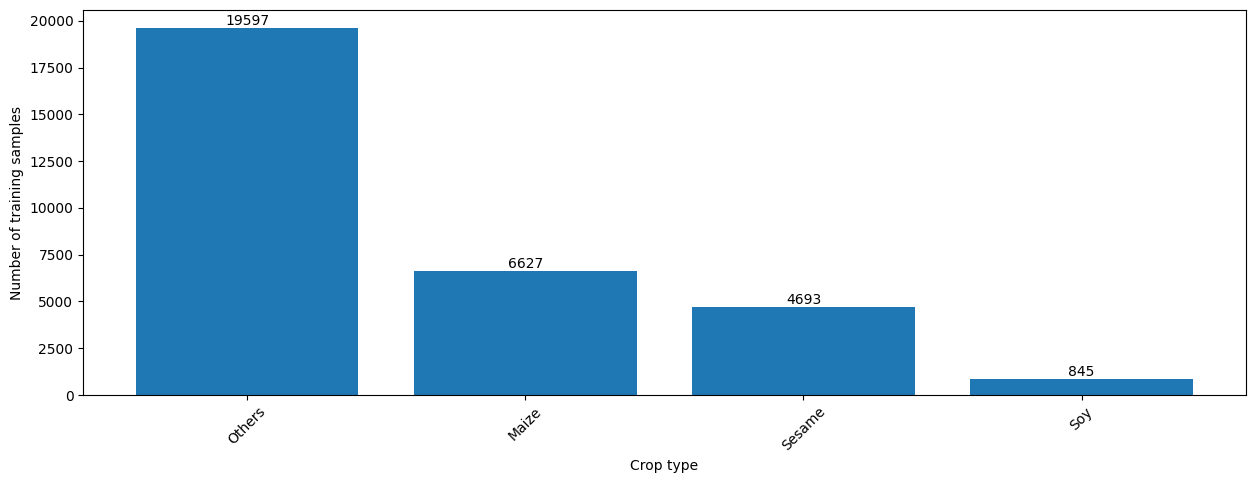

In [6]:
# Insert data into a Pandas DataFrame
model_input_df = pd.DataFrame(model_input, columns=column_names)
# Investigate value counts for each class
class_counts=model_input_df[label_col].value_counts()
class_indices=class_counts.index
labels_dict_inv={value: key for key, value in labels_dict.items()}
class_legends=[labels_dict_inv[class_indices[i]] for i in range(len(class_indices))]
plt.figure(figsize=(15,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of training samples')
plt.gca().set_xlabel('Crop type')
plt.gca().tick_params(axis='x', rotation=45)

## Class rebalancing

Reduce number of samples for classes more than twice the number of any others.

In [7]:
for i in range(len(class_counts)):
    if class_counts.values[i]>10*class_counts.values[-1]:
        n_samples_dropped=class_counts.values[i]-10*class_counts.values[-1]
        print('dropping {} of {} samples'.format(n_samples_dropped,labels_dict_inv[class_indices[i]]))
        model_input_df.drop(model_input_df[model_input_df[label_col]==class_indices[i]].sample(n=n_samples_dropped).index,
                            axis=0,inplace=True)
    else:
        print('no balancing needed')

dropping 11147 of Others samples
no balancing needed
no balancing needed
no balancing needed


In [8]:
# split into features and labels
X = model_input_df.drop(label_col, axis=1)[columns_to_use].values
y = model_input_df[[label_col]].values.ravel()

## Fit, tune and evaluate multiple models using nested cross-validation

This step allows us to train and tune mutliple models on fixed subsets of our data.

When performing cross validation, data is split into `n` folds. One fold is kept aside as test data, and the rest is used to train a model. This step is repeated until each fold has been used as a test set, having been trained on the other folds. From each fold, we get an estimate of the performance, which can be averaged to understand expected performance of a model on unseen data.

### Get number of cpus available

In [9]:
ncpus = round(get_cpu_quota())
print("ncpus = " + str(ncpus))

ncpus = 62


### Drop correlated features

In [10]:
## function for removing correlated variables
def DropCorrelatedFeatures(X_,removal_threshold=0.9):
    to_drop = set() # set of features to drop
    correlation_matrix = X_.corr().abs()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (correlation_matrix.iloc[i, j] >= removal_threshold) and (correlation_matrix.columns[j] not in to_drop):
                colname = correlation_matrix.columns[i]
                to_drop.add(colname)
    to_drop=list(to_drop)
    X_dropped=X_.copy()
    X_dropped = X_dropped.drop(to_drop, axis=1)
    return X_dropped

In [11]:
removal_threshold=0.9
X_=model_input_df.drop(label_col, axis=1)[columns_to_use]
X_dropped=DropCorrelatedFeatures(X_,removal_threshold=removal_threshold)
X_dropped.columns

Index(['blue_s2_Q4_2021', 'green_s2_Q4_2021', 'red_s2_Q4_2021',
       'nir_s2_Q4_2021', 'swir_1_s2_Q4_2021', 'NDVI_s2_Q4_2021',
       'MNDWI_s2_Q4_2021', 'blue_s2_Q1_2022', 'red_s2_Q1_2022',
       'nir_s2_Q1_2022', 'swir_1_s2_Q1_2022', 'red_edge_1_s2_Q1_2022',
       'NDVI_s2_Q1_2022', 'MNDWI_s2_Q1_2022', 'blue_s2_Q2_2022',
       'green_s2_Q2_2022', 'red_s2_Q2_2022', 'nir_s2_Q2_2022',
       'swir_1_s2_Q2_2022', 'NDVI_s2_Q2_2022', 'MNDWI_s2_Q2_2022',
       'blue_s2_Q3_2022', 'red_s2_Q3_2022', 'nir_s2_Q3_2022',
       'swir_1_s2_Q3_2022', 'red_edge_1_s2_Q3_2022', 'NDVI_s2_Q3_2022',
       'MNDWI_s2_Q3_2022', 'blue_s2_annual_2021', 'red_s2_annual_2021',
       'nir_s2_annual_2021', 'swir_1_s2_annual_2021',
       'red_edge_1_s2_annual_2021', 'smad_s2_annual_2021',
       'emad_s2_annual_2021', 'bcmad_s2_annual_2021', 'NDVI_s2_annual_2021',
       'MNDWI_s2_annual_2021', 'blue_s2_semiannual_2021_07',
       'nir_s2_semiannual_2021_07', 'smad_s2_semiannual_2021_07',
       'emad_s2_se